# Einleitung

Der Bundesstaat Berlin veröffentlicht jährlich die Details von staatlichen Ausgaben. Die Datensatz und Dateidefinitionen sind zu finden unter: https://www.berlin.de/sen/finanzen/service/zuwendungsdatenbank/

Der Datensatz umfasst 49772 Einträge (Stand Dez. 2021) und setzt sich aus den folgenden 7 Attributen zusammen:

<ul>
<li>Name: Bezeichnung des Empfängers der Zuwendung</li>
<li>Geber: Bezeichnung des Gebers der Zuwendung</li>
<li>Art: Typus der Zuwendung</li>
<li>Jahr: Jahr in dem die Zuwendung erteilt wurde</li>
<li>Anschrift: Postanschrift des Empfängers</li>
<li>Politikbereich: Zuordnung der Zuwendung zum relevanten Politikbereich</li>
<li>Zweck: Beschribung des Verwendungszwecks</li>
<li>Betrag: Höhe der Zuwendung</li>
</ul>

Die Zielsetzung besteht in der Erstellung eines Klassifikator-Modells, welches in der Lage ist den Plotikbereich, auf Basis aller übrigen Attribute, vorherzusagen.

**Keywords: Multi Label Classification, Natural Language Processing**

# Paket Import & Datenbeschaffung

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import re

import nltk 
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

from scipy.sparse import hstack
from scipy.stats import uniform, loguniform, randint
from scipy.stats import chi2_contingency

import sklearn
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_transformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.dummy import DummyClassifier
from sklearn.metrics import log_loss
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import RandomizedSearchCV
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.utils.testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning
from sklearn.exceptions import FitFailedWarning

Aus unbekannten Gründen kann nicht der gesamte Datensatz auf einmal geladen werden. Es ist jedoch möglich in nach Jahren zu laden, was für den Zeitraum 2016-2020 vertretbar ist.

In [3]:
source_url = 'https://www.berlin.de/sen/finanzen/service/zuwendungsdatenbank/index.php/index/print.html?q=&name=&anschrift=&zweck=&jahr=2016'
df_2016 = pd.read_html(source_url)
df_2016[0].head()

,Name,Geber,Art,Jahr
,Anschrift,Politikbereich,Zweck,Betrag
0,ImPULS e. V.,Bezirksamt Neukölln,Projektförderung,2016.0
1,"Bat-Yam-Platz 1, 12353 Berlin",Bildung,Sprachschulungen für aktive Gropiusstädter,6607.0
2,Verein zur Förderung der Kommunikation unter G...,Bezirksamt Neukölln,Projektförderung,2016.0
3,"Löwensteinring 22, 12353 Berlin",Familie,Kinderbildungscafe,2500.0
4,Verein zur Förderung der Kommunikation unter G...,Bezirksamt Neukölln,Projektförderung,2016.0


In [4]:
df_2017 = pd.read_html('https://www.berlin.de/sen/finanzen/service/zuwendungsdatenbank/index.php/index/print.html?q=&name=&anschrift=&zweck=&jahr=2017')
df_2018 = pd.read_html('https://www.berlin.de/sen/finanzen/service/zuwendungsdatenbank/index.php/index/print.html?q=&name=&anschrift=&zweck=&jahr=2018')
df_2019 = pd.read_html('https://www.berlin.de/sen/finanzen/service/zuwendungsdatenbank/index.php/index/print.html?q=&name=&anschrift=&zweck=&jahr=2019')
df_2020 = pd.read_html('https://www.berlin.de/sen/finanzen/service/zuwendungsdatenbank/index.php/index/print.html?q=&name=&anschrift=&zweck=&jahr=2020')

In [5]:
df_2016[0].head()

,Name,Geber,Art,Jahr
,Anschrift,Politikbereich,Zweck,Betrag
0,ImPULS e. V.,Bezirksamt Neukölln,Projektförderung,2016.0
1,"Bat-Yam-Platz 1, 12353 Berlin",Bildung,Sprachschulungen für aktive Gropiusstädter,6607.0
2,Verein zur Förderung der Kommunikation unter G...,Bezirksamt Neukölln,Projektförderung,2016.0
3,"Löwensteinring 22, 12353 Berlin",Familie,Kinderbildungscafe,2500.0
4,Verein zur Förderung der Kommunikation unter G...,Bezirksamt Neukölln,Projektförderung,2016.0


Leider liegen die Daten in einer ungeeigneten Tabellenstrukur vor und müssen zunächst in eine konventionelle Form überführt werden.

In [6]:
# Routine zum Transformieren der Originaltabellen in Standardform
def table_rearanger(df):
    # obere Hälfte der Spaltenlabel und gerade Zeilen in linke Teiltabelle
    df_1 = df.iloc[::2,:].reset_index(drop=True)
    df_1.columns = df.columns.levels[0][df.columns.codes[0]]
    
    # untere Hälfte der Spaltenlabel und ungerade Zeilen in rechte Teiltabelle
    df_2 = df.iloc[1::2,:].reset_index(drop=True)
    df_2.columns = df.columns.levels[1][df.columns.codes[1]]
    
    # horizontaler Merge ergibt gesamte Tabelle im gewünschten Format
    return pd.concat([df_1, df_2], axis=1)

In [7]:
table_rearanger(df_2016[0]).head()

,Name,Geber,Art,Jahr,Anschrift,Politikbereich,Zweck,Betrag
0,ImPULS e. V.,Bezirksamt Neukölln,Projektförderung,2016.0,"Bat-Yam-Platz 1, 12353 Berlin",Bildung,Sprachschulungen für aktive Gropiusstädter,6607.0
1,Verein zur Förderung der Kommunikation unter G...,Bezirksamt Neukölln,Projektförderung,2016.0,"Löwensteinring 22, 12353 Berlin",Familie,Kinderbildungscafe,2500.0
2,Verein zur Förderung der Kommunikation unter G...,Bezirksamt Neukölln,Projektförderung,2016.0,"Löwensteinring 22, 12353 Berlin",Jugend,Service Learning,15364.0
3,ABC Zentrum Berlin e. V.,Bezirksamt Mitte,Projektförderung,2016.0,"Luise-Zietz-Straße 43, 12683 Berlin",Stadtentwicklung,Sachmittel für freiwilliges Engagement in Nach...,1750.0
4,casablanca gGmbH,Bezirksamt Mitte,Projektförderung,2016.0,"Pistoriusstraße 108a, 13086 Berlin",Stadtentwicklung,Sachmittel für freiwilliges Engagement in Nach...,980.0


In [8]:
# vertikaler Merge aller Jahrestabellen ergibt vollen Datensatz
df_original_full = pd.concat([table_rearanger(df_2016[0]),
                              table_rearanger(df_2017[0]),
                              table_rearanger(df_2018[0]),
                              table_rearanger(df_2019[0]),
                              table_rearanger(df_2020[0])]).reset_index(drop=True)

In [9]:
df_original_full.head()

,Name,Geber,Art,Jahr,Anschrift,Politikbereich,Zweck,Betrag
0,ImPULS e. V.,Bezirksamt Neukölln,Projektförderung,2016.0,"Bat-Yam-Platz 1, 12353 Berlin",Bildung,Sprachschulungen für aktive Gropiusstädter,6607.0
1,Verein zur Förderung der Kommunikation unter G...,Bezirksamt Neukölln,Projektförderung,2016.0,"Löwensteinring 22, 12353 Berlin",Familie,Kinderbildungscafe,2500.0
2,Verein zur Förderung der Kommunikation unter G...,Bezirksamt Neukölln,Projektförderung,2016.0,"Löwensteinring 22, 12353 Berlin",Jugend,Service Learning,15364.0
3,ABC Zentrum Berlin e. V.,Bezirksamt Mitte,Projektförderung,2016.0,"Luise-Zietz-Straße 43, 12683 Berlin",Stadtentwicklung,Sachmittel für freiwilliges Engagement in Nach...,1750.0
4,casablanca gGmbH,Bezirksamt Mitte,Projektförderung,2016.0,"Pistoriusstraße 108a, 13086 Berlin",Stadtentwicklung,Sachmittel für freiwilliges Engagement in Nach...,980.0


Bemerkung: Die volle Tabelle enthält 5 Einträge mehr als eigentlich vorhanden. Es handelt sich dabei um Einträge welche nur aus NaNs bestehen und an den Enden der einzelnen Jahrestabellen auftreten. Sie sind irrelevant und können direkt entfernt werden.

In [10]:
df_original_full.dropna(how='all', inplace=True)

# Datenexploration

Der folgende Abschnitt enthält eine individuelle Inspektion aller Attribute bei der Probleme und Besonderheiten des jeweiligen Attributs identifiziert werden. Am Datensatz selber werden keine nachhaltigen Änderungen vorgenommen. Es werden lediglich Strategien entwickelt, welche später dazu eingesetz werden die Daten für das Machine Learning vorzubereiten.

In [11]:
df_full = df_original_full.copy()

In [12]:
df_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49773 entries, 0 to 49776
Data columns (total 8 columns):
Name              49772 non-null object
Geber             49773 non-null object
Art               49773 non-null object
Jahr              49773 non-null float64
Anschrift         49768 non-null object
Politikbereich    49773 non-null object
Zweck             49764 non-null object
Betrag            49773 non-null float64
dtypes: float64(2), object(6)
memory usage: 3.4+ MB


In [13]:
# werte leere Strings und Zahlenwerte <= 0 als fehlende Einträge und behandle wie NaN
df_full.replace('', np.NaN, inplace=True)

df_full.replace(0, np.NaN, inplace=True)
df_full[df_full.Jahr <= 0] = np.NaN
df_full[df_full.Betrag <= 0] = np.NaN

## Geber

Wie aus dem info-Output entnommen werden kann,enthält das Attribut keine fehlenden Werte. Es handelt sich um ein Attribut vom Typ String.

In [14]:
# ignoriere Unterschiede bei der Groß- und Kleinschreibung
df_full.Geber = df_full.Geber.str.lower()

In [15]:
len(Counter(df_full.Geber))

36

Es gibt 36 verschiedene Ausprägungen für das Attribut, daher ergibt es Sinn es als kategorisches Attribut zu behandeln. Es bietet sich jedoch an, die Auswahl an Kategorien so zu beschränken, dass nur solche mit einer Häufigkeit > 400 berücksichtigt werden. Dieser Grenzwert ist relativ willkürlich und könnte nötigenfalls angepasst werden.

In [16]:
# allgemeine Routine um eine Spalte eines Dataframes auf Werte zu reduzieren die mehr als n-mal auftreten.
# Rest wird default Wert zugeteilt.
def reduce_categories(frame, attribute, min_samples):
    # erstelle counter objekt für Splateneinträge
    counter = Counter(frame[attribute])
    # extrahiere keys mit valuecount > threshold
    names = np.array(list(counter.keys()))[np.array(list(counter.values())) > min_samples]
    # erstelle neuen Dataframe 
    # benenne in betreffender Spalte alle Einträge 'Sonstige' falls nicht in keylist
    # gib neuen frame zurück
    new_frame = frame.copy()
    new_frame[attribute] = new_frame[attribute].apply(lambda x: x if x in names else 'sonstige')
    return new_frame

In [17]:
test = reduce_categories(df_full, 'Geber', 400)

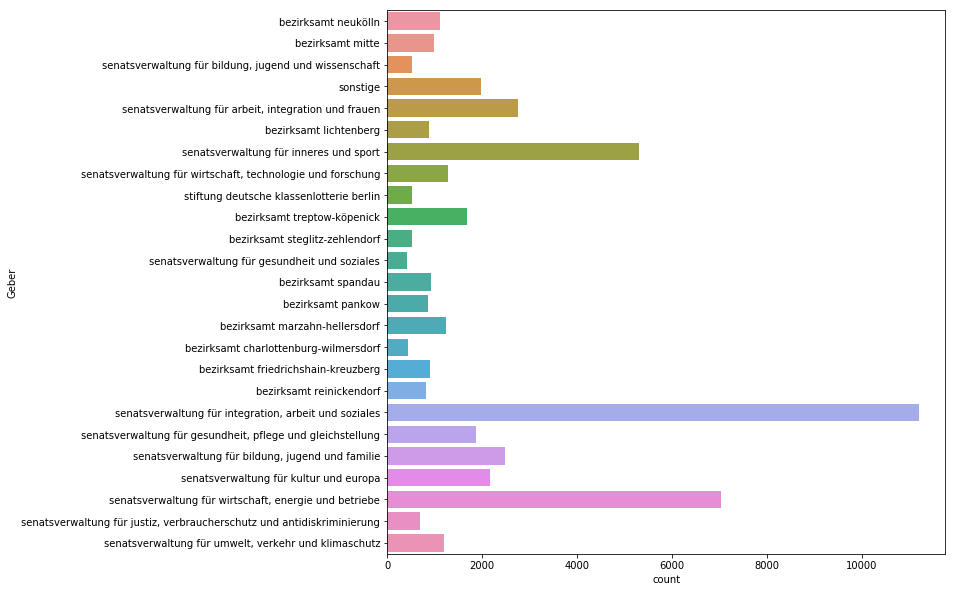

In [18]:
f, ax = plt.subplots(figsize=(10, 10))
sns.countplot(y=test.Geber);

An dieser Stelle wäre es interessant zu wissen, inwieweit 'Geber' mit der Zielgröße 'Politikbereich' korreliert ist. Hierzu wird ein chi2-Test über eine Kontingenztafel(Geber VS Politikbereich) durchgeführt.

In [19]:
contingency = pd.crosstab(columns=test['Politikbereich'], index=test['Geber'])

In [20]:
# exeplarischer Auszug aus der Kontingenztafel
contingency.iloc[:7,:7]

Politikbereich,Antidiskriminierung,Arbeit,"Bauen, Wohnen",Berlin-Image,Bildung,"Bürgerschaftliches Engagement, Bürgerbeteiligung",Denkmalschutz
Geber,,,,,,,
bezirksamt charlottenburg-wilmersdorf,0,0,0,0,72,0,0
bezirksamt friedrichshain-kreuzberg,7,2,4,0,14,167,0
bezirksamt lichtenberg,0,0,0,0,29,128,0
bezirksamt marzahn-hellersdorf,0,0,0,0,39,37,0
bezirksamt mitte,0,0,0,0,1,0,0
bezirksamt neukölln,4,9,6,0,161,68,0
bezirksamt pankow,0,0,0,0,148,0,0


In [21]:
chi2, p , _, _ = chi2_contingency(contingency)
print('Chi 2 score: %f' %(chi2))
print('p value: %f' %(p))

Chi 2 score: 315055.191086
p value: 0.000000


Leider sind diese Ergebnisse völlig unbrauchbar, da der Chi2-Test nur für ausreichend dicht besetzte Datenseätze gültig ist.

[Das selbe Problem tritt bei allen anderen Attributen ebenso auf. Eine direkte Bestimmung der Relevanz eines Attributs für die Zielgröße ist auf diese Art nicht möglich.]

## Art

Attribut enthält keine fehlenden Werte. Typ String

In [22]:
df_full.Art = df_full.Art.str.lower()
len(Counter(df_full.Art))

2

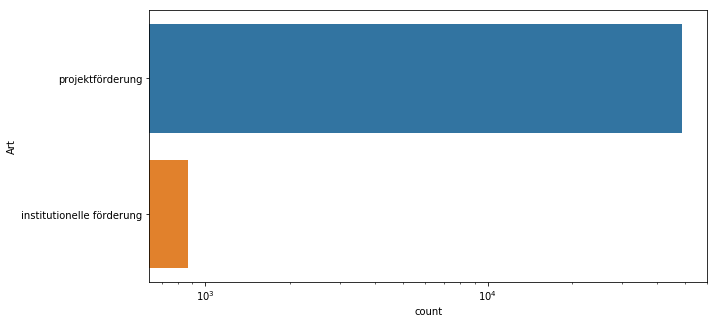

In [23]:
test = reduce_categories(df_full, 'Art', 400)

f, ax = plt.subplots(figsize=(10, 5))
plt.xscale('log')
sns.countplot(y=test.Art);

Keine Reduktion der Kategorien notwendig. Kann so beibehalten werden. Seltenste Ausprägung noch hinreichend häufig.

## Politikbereich

Attribut enthält keine fehlenden Werte. Typ String

In [24]:
df_full.Politikbereich = df_full.Politikbereich.str.lower()
len(Counter(df_full.Politikbereich))

31

In [25]:
Counter(df_full.Politikbereich).most_common()[-5:]

[('bauen, wohnen', 45),
 ('finanzen', 44),
 ('berlin-image', 2),
 ('tierschutz', 2),
 ('medien', 1)]

Obwohl es sich hierbei um die zu bestimmende Zielgröße handelt, ist es auch hier unabdingbar, die Anzahl an Kategorien zu reduzieren. Es ist ausgeschlossen, dass ein ML Model erlernen kann Lables vorherzusagen, welche praktisch nie auftreten.

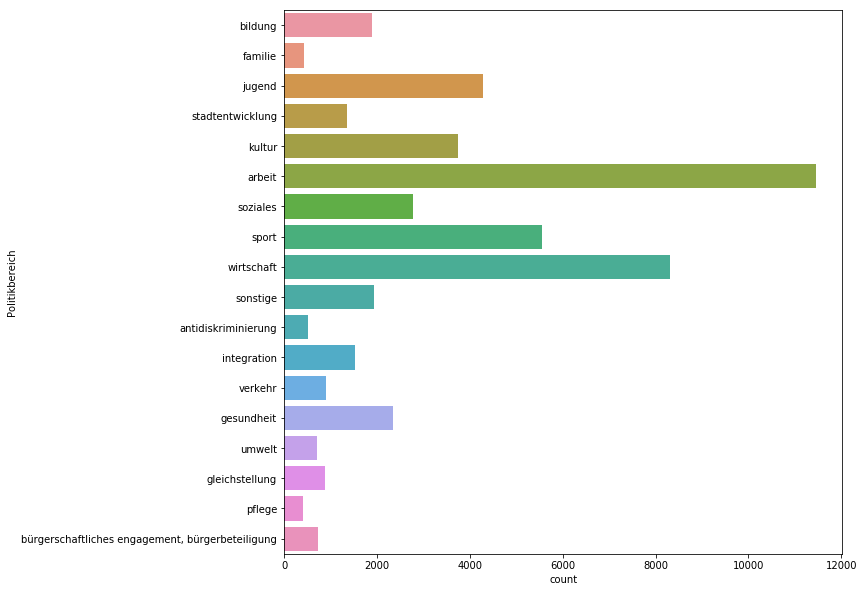

In [26]:
test = reduce_categories(df_full, 'Politikbereich', 400)

f, ax = plt.subplots(figsize=(10, 10))
sns.countplot(y=test.Politikbereich);

Leider ist der Datensatz hiermit immer noch sehr schlecht ausbalaciert. Möglicherweise muss hier weiter reduziert werden, oder es müssen andere Techniken herangezogen werden.

## Anschrift

Es ist unmittelbar ersichtlich, dass die Anschrift an sich kein sinnvoles Attribut ist, da sie direkt mit den Names des Empfängers korreliert ist und daher praktisch redundant ist. Die einzelnen Komponeneten der Anschrift könnten jedoch aufschlussreich sein.

Eine Hand voll Adressen ist nicht vorhanden. Möglicherweise können die fehlenden Werte über den Namen des Empfängers ermittelt werden, allerdings wird hier aufgrund des geringen Nutzens davon abgesehen. Entsprechende Einträge werden als 'Unbekannt' deklariert.

In [27]:
df_full.Anschrift.fillna('unbekannt', inplace=True)

In [28]:
df_full.Anschrift = df_full.Anschrift.str.lower()
len(Counter(df_full.Anschrift))

9144

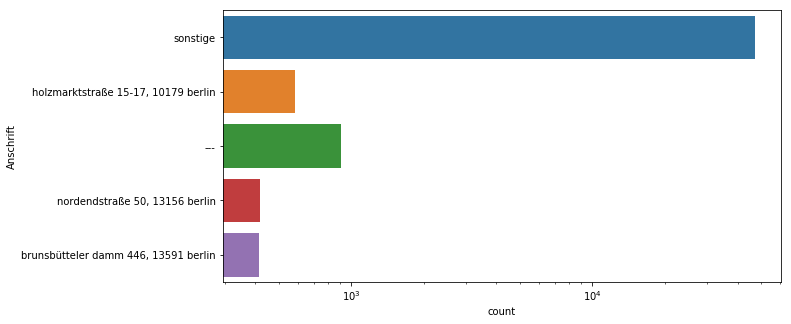

In [29]:
test = reduce_categories(df_full, 'Anschrift', 400)

f, ax = plt.subplots(figsize=(10, 5))
plt.xscale('log')
sns.countplot(y=test.Anschrift);

Die Anschrift ist als kategorisches Attribut wohl kaum zu gebrauchen. Die Ausprägung ist zu divers, sodass ein Großteil aller Einträge als 'Sonstige' abgetan werden müsste.

Eine Vielzahl an Adressen scheint unbekannt zu sein. Diese liegen nicht als NaN sondern als '---' vor.

In [30]:
test = df_full.replace('---', 'unbekannt,')   # das komma am Ende ist für split_adress wichtig

In [31]:
# Spaltet Anschrift-Spalte eines Dataframes in Strasse, PLZ und Ort und erzeugt seperate Spalten 
def split_adress(frame):
    # extrahiert alles vor dem letzten Komma -> Strassenname
    def get_street(string):
        try:
            return ''.join(string.split(',')[:-1])
        except:
            return 'unbekannt'
    
    # extrahiert alles nach dem letzen Komma, vor dem letzen Leerzeichen -> PLZ
    def get_code(string):
        try:
            return string.split(',')[-1].split(' ')[1] 
        except:
            return 'unbekannt'
    
    # extrahiert alles nach dem letzen Komma, nach dem letzen Leerzeichen -> Ort
    def get_city(string):
        try:
            return string.split(',')[-1].split(' ')[2] 
        except:
            return 'unbekannt'
    
    # erstelle neuen Dataframe, extrahiere Strasse, Ort und PLZ
    # füge als neue Spalten hinzu
    # entferne Anschrift und gib neuen frame zurück
    new_frame = frame.copy()
    new_frame['Strasse'] = new_frame['Anschrift'].astype(str).apply(get_street)
    new_frame['PLZ'] = new_frame['Anschrift'].astype(str).apply(get_code)
    new_frame['Ort'] = new_frame['Anschrift'].astype(str).apply(get_city)
    
    return new_frame.drop(columns=['Anschrift'])

In [32]:
test = split_adress(test)

print('Anzahl unterschiedlicher Strassennamen: %i' %(len(Counter(test.Strasse))))
print('Anzahl unterschiedlicher Postleitzahlen: %i' %(len(Counter(test.PLZ))))
print('Anzahl unterschiedlicher Städte: %i' %(len(Counter(test.Ort))))

Anzahl unterschiedlicher Strassennamen: 8706
Anzahl unterschiedlicher Postleitzahlen: 592
Anzahl unterschiedlicher Städte: 139


Der Strassename kann aus den selben Gründen, wie die Anchrift verworfen werden. Die Postleitzahl und der Ort könnten nach drastischer Reduktion der Kategorien dennoch als kategorische Attribute verwendet werden.

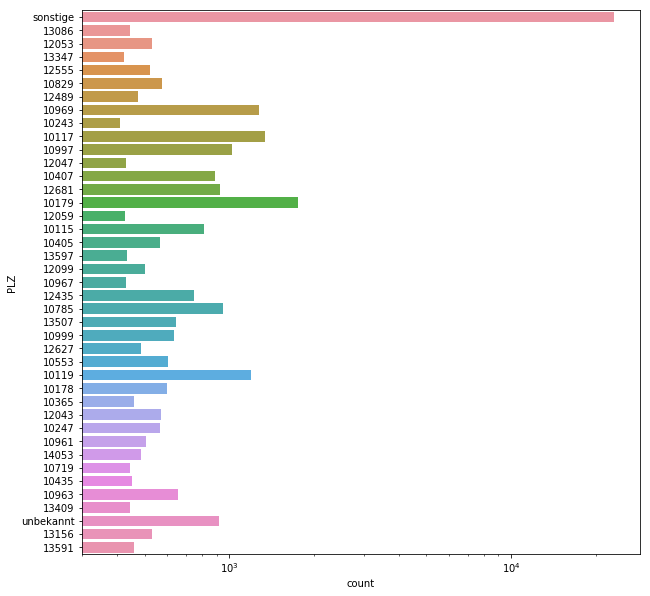

In [33]:
test = reduce_categories(test, 'PLZ', 400)

f, ax = plt.subplots(figsize=(10, 10))
plt.xscale('log')
sns.countplot(y=test.PLZ);

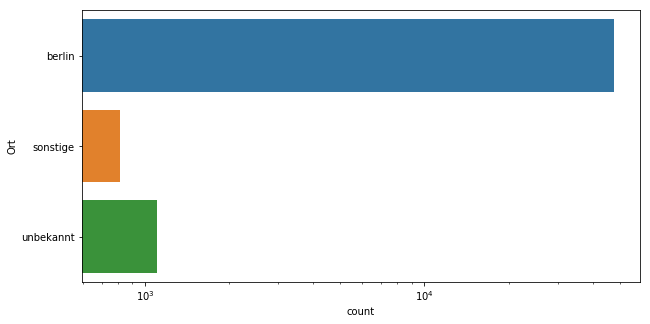

In [34]:
test = reduce_categories(test, 'Ort', 400)

f, ax = plt.subplots(figsize=(10, 5))
plt.xscale('log')
sns.countplot(y=test.Ort);

## Jahr

Numerisches Attribut ohne fehlenden Werte.

In [35]:
df_full.Jahr.describe()

count    49773.000000
mean      2018.173387
std          1.400291
min       2016.000000
25%       2017.000000
50%       2018.000000
75%       2019.000000
max       2020.000000
Name: Jahr, dtype: float64

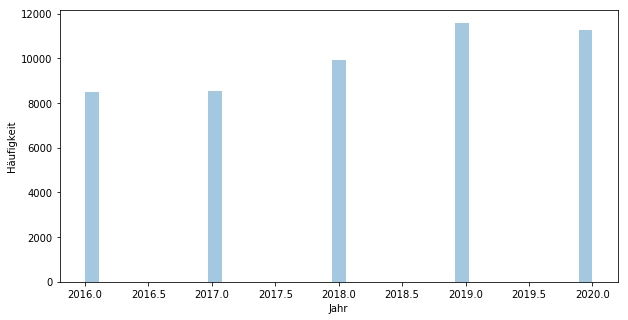

In [36]:
f, ax = plt.subplots(figsize=(10, 5))
ax.set_ylabel('Häufigkeit')
sns.distplot(df_full.Jahr, kde=False);

"Jahr" hat nur 5 verschiedene, diskrete Ausprägungen und sollte wohl eher als kategorisches Attribut behandelt werden.

## Betrag

Numerisches Attribut ohne fehlenden Werte.

In [37]:
df_full.Betrag.describe()

count    4.977300e+04
mean     2.021572e+05
std      1.666412e+06
min      1.000000e+02
25%      5.322000e+03
50%      2.000000e+04
75%      8.734200e+04
max      1.148264e+08
Name: Betrag, dtype: float64

/home/sninfa/Dokumente/Job/Portfolio Projects/env/lib/python3.5/site-packages/matplotlib/ticker.py:2241: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  "Data has no positive values, and therefore cannot be "


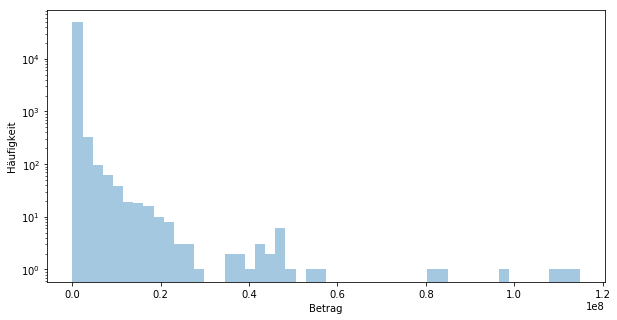

In [38]:
f, ax = plt.subplots(figsize=(10, 5))
ax.set_ylabel('Häufigkeit')
ax.set(yscale="log")
sns.distplot(df_full.Betrag, kde=False);

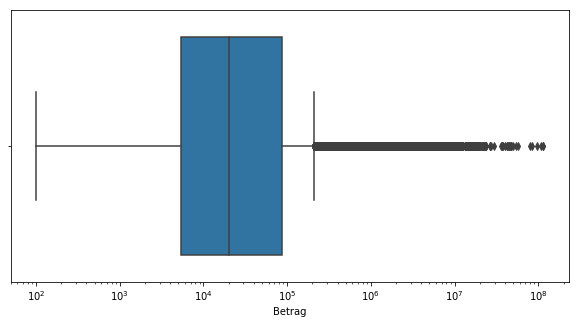

In [39]:
f, ax = plt.subplots(figsize=(10, 5))
ax.set(xscale="log")
sns.boxplot(df_full.Betrag);

In [40]:
df_full.Betrag[df_full.Betrag > 2e5].count()

6646

Die Größen der jeweils ausgezahlten Geldmengen sind über einen Zahlenraum verteilt welcher sich über mehrere Größenordnungen erstreckt. Die Verteilung ist darüber hinaus sehr ungleichmäßig. Es empfielt sich daher, die Daten in diskrete Bins zu verpacken. Deren Grenzen sollten so gezogen werden, dass sie möglichst die gleiche Menge an Datenpunkten abdecken.

In [41]:
# Routine zum Diskretisieren von numerischen Attributen mit Quantilen als Bin-Grenzen.
# Äußere Grenzen sind 0 und unendlich.
# Gibt nur eine transformierte Spalte zurück; nicht den ganzen frame
def bucketize_num(frame, column):
    return pd.cut(frame[column], [0,
                                  frame[frame[column] > 0][column].quantile(0.25),
                                  frame[frame[column] > 0][column].quantile(0.5),
                                  frame[frame[column] > 0][column].quantile(0.75),
                                  np.inf])

In [42]:
Counter(bucketize_num(df_full, 'Betrag'))

Counter({Interval(0.0, 5322.0, closed='right'): 12466,
         Interval(5322.0, 20000.0, closed='right'): 12479,
         Interval(20000.0, 87342.0, closed='right'): 12385,
         Interval(87342.0, inf, closed='right'): 12443})

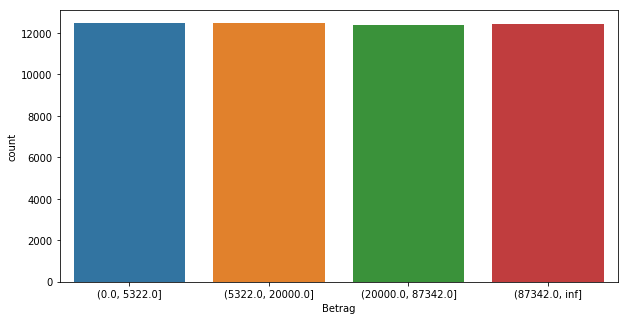

In [43]:
f, ax = plt.subplots(figsize=(10, 5))
sns.countplot(bucketize_num(df_full, 'Betrag'));

## Name

Attribut in String-Form. Ein Eintrag fehlt und könnte über die Anschrift ermittelt werden. Wird aber aus Gründen der Einfachheit durch leeren String ersetzt.

In [44]:
df_full.Name.fillna('', inplace=True)

In [45]:
len(Counter(df_full.Name))

11298

In [46]:
Counter(df_full.Name).most_common(25)

[('Verschiedene natürliche Personen', 566),
 ('GFBM-gemeinnützige Gesellschaft für berufsbildende Maßnahmen mit beschränkter Haftung',
  407),
 ('AGRARBÖRSE Deutschland Ost e. V.', 312),
 ('BVG', 304),
 ('Alte Feuerwache e. V.', 288),
 ('C.U.B.A. gGmbH', 286),
 ('Albatros gemeinnützige Gesellschaft für soziale und gesundheitliche Dienstleistungen mbH',
  281),
 ('Christliches Jugenddorfwerk Deutschlands gemeinnütziger e. V. (CJD)', 266),
 ('Schildkröte GmbH', 253),
 ('agens Arbeitsmarktservice gGmbH', 203),
 ('pad - präventive, altersübergreifende Dienste im sozialen Bereich - gGmbH',
  203),
 ('Sozial-kulturelle Netzwerke casa e. V.', 201),
 ('Kulturring in Berlin e. V.', 197),
 ('WeTeK Berlin gGmbH, gemeinnützige Gesellschaft für Qualifizierung, Ausbildung und Jugendkultur',
  190),
 ('Verschiedene Gesellschaften bürgerlichen Rechts', 190),
 ('Chance BJS gGmbH', 190),
 ('bildungsmarkt vulkan & waldenser gmbh', 188),
 ('CJD Berlin-Brandenburg', 171),
 ('Caritasverband für das Erzbistu

Genau wie die Anschreiben, sind auch die Namen der Enpfänger nicht als kategorisches Merkmal zu gebrauchen. Im Gegensatz zur Anschrift, kann in diesem Fall aber inhaltliche Information aus dem Namen selbst gewonnen werden. Dieses Attribut ist also predestiniert für NLP.

Bemerkung: Anscheinend sind die Namen der Empfänger nicht immer eindeutig. Siehe "BVG" und "Berliner Verkehrsbetriebe (BVG) AdöR", welche offensichtlich die selbe Institution bezeichnen. Falls möglich muss ein Weg gefunden werden Synonyme zu berücksichtigen.

In [47]:
nltk.download('punkt')
nltk.download('stopwords')

stemmer = SnowballStemmer("german")
stop_words = set(stopwords.words("german"))

[nltk_data] Downloading package punkt to /home/sninfa/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/sninfa/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [48]:
# entfernt alle Sonderzeichen, Tabs, Stoppwörter und einzelne Zeichen
# reduziert auf wortstamm
# setz alles in Kleinschreibung
def text_cleaning(text):
    # definiere zu entfernendes
    RE_WSPACE = re.compile(r"\s+", re.IGNORECASE)
    RE_ASCII = re.compile(r"[^A-Za-zÀ-ž ]", re.IGNORECASE)
    RE_SINGLECHAR = re.compile(r"\b[A-Za-zÀ-ž]\b", re.IGNORECASE)

    # ersetze unerwünschtes durch Leerzeichen
    text = re.sub(RE_ASCII, " ", text)
    text = re.sub(RE_SINGLECHAR, " ", text)
    text = re.sub(RE_WSPACE, " ", text)

    # forme Fließtext zu Liste von tokens
    word_tokens = word_tokenize(text)
    words_tokens_lower = [word.lower() for word in word_tokens]

    # reduziere tokens auf Wortstämme
    words_filtered = [
        stemmer.stem(word) for word in words_tokens_lower if word not in stop_words
    ]

    # füge tokens zu einem String zusammen und gib zurück
    text_clean = ' '.join(words_filtered)
    
    if text_clean == np.NaN:
        return ''
    else:
        return text_clean

In [49]:
df_full.Name = df_full.Name.apply(text_cleaning)
df_full.head()

,Name,Geber,Art,Jahr,Anschrift,Politikbereich,Zweck,Betrag
0,impul,bezirksamt neukölln,projektförderung,2016.0,"bat-yam-platz 1, 12353 berlin",bildung,Sprachschulungen für aktive Gropiusstädter,6607.0
1,verein forder kommunikation gropiusstadt frau,bezirksamt neukölln,projektförderung,2016.0,"löwensteinring 22, 12353 berlin",familie,Kinderbildungscafe,2500.0
2,verein forder kommunikation gropiusstadt frau,bezirksamt neukölln,projektförderung,2016.0,"löwensteinring 22, 12353 berlin",jugend,Service Learning,15364.0
3,abc zentrum berlin,bezirksamt mitte,projektförderung,2016.0,"luise-zietz-straße 43, 12683 berlin",stadtentwicklung,Sachmittel für freiwilliges Engagement in Nach...,1750.0
4,casablanca ggmbh,bezirksamt mitte,projektförderung,2016.0,"pistoriusstraße 108a, 13086 berlin",stadtentwicklung,Sachmittel für freiwilliges Engagement in Nach...,980.0


In [50]:
# bereinige auftretende NaNs durch Ersetzen
df_full.Name.fillna('', inplace=True)

In [51]:
# trainiere Vektorisierer
# ignoriere Wörter die mehr als 30% aller Wörter ausmachen, oder weniger als 10 mal auftreten
# bewusst keine ngrame verwendet, da Text keine echten Sätze enthält und Kontext weniger wichtig ist
vectorizer = TfidfVectorizer(
    max_df=0.3, min_df=10, ngram_range=(1, 1)
)
vectorizer.fit(df_full.Name)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=0.3, max_features=None,
                min_df=10, ngram_range=(1, 1), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None)

In [52]:
vectorizer.transform(df_full.Name)

<49773x1904 sparse matrix of type '<class 'numpy.float64'>'
	with 152925 stored elements in Compressed Sparse Row format>

## Zweck

String-Attribut mit mehreren fehlenden Werten. Es gibt keine plausible Möglichkeit diese zu interpolieren oder zu ermitteln. Entsprechende Einträge müssen verworfen, oder durch leere Strings ersetzt werden.

In [53]:
df_full.Zweck.fillna('', inplace=True)

In [54]:
len(Counter(df_full.Zweck))

24755

In [55]:
Counter(df_full.Zweck).most_common(10)

[('Kosten für die Beschäftigung von Übungsleitern', 2762),
 ('Coaching', 637),
 ('Unterstützung der Aufbauphase von Existenzgründungen und Startups', 572),
 ('Erweiterung einer Betriebsstätte', 564),
 ('Elektrofahrzeug', 559),
 ('Digitalprämie Berlin', 400),
 ('Kosten für die Beschäftigung von hauptberuflichen Verwaltungskräften in Sportverbänden und -vereinen',
  321),
 ('Kosten für die Beschäftigung von hauptberuflichen Trainern mit Schwerpunkt im Kinder- und Jugendsport',
  287),
 ('Bauliche Maßnahme - Schaffung von Plätzen- Kitaausbauprogramm', 268),
 ('Errichtung einer Betriebsstätte', 265)]

Insgesamt hat 'Zweck' sehr viele Gemeinsamkeiten mit 'Name' und wird entsprechend auch als Textattribut behandelt und ist somit ein Fall für NLP.

In [56]:
df_full.Zweck = df_full.Zweck.apply(text_cleaning)
df_full.head()

,Name,Geber,Art,Jahr,Anschrift,Politikbereich,Zweck,Betrag
0,impul,bezirksamt neukölln,projektförderung,2016.0,"bat-yam-platz 1, 12353 berlin",bildung,sprachschul aktiv gropiusstadt,6607.0
1,verein forder kommunikation gropiusstadt frau,bezirksamt neukölln,projektförderung,2016.0,"löwensteinring 22, 12353 berlin",familie,kinderbildungscaf,2500.0
2,verein forder kommunikation gropiusstadt frau,bezirksamt neukölln,projektförderung,2016.0,"löwensteinring 22, 12353 berlin",jugend,servic learning,15364.0
3,abc zentrum berlin,bezirksamt mitte,projektförderung,2016.0,"luise-zietz-straße 43, 12683 berlin",stadtentwicklung,sachmittel freiwill engagement nachbarschaft,1750.0
4,casablanca ggmbh,bezirksamt mitte,projektförderung,2016.0,"pistoriusstraße 108a, 13086 berlin",stadtentwicklung,sachmittel freiwill engagement nachbarschaft,980.0


Bemerkung: Falls möglich, sollte versucht werden zusammengesetze Wörter wie 'Familienberatungsstelle' zu separieren.

In [57]:
# bereinige auftretende NaNs durch Ersetzen
df_full.Zweck.fillna('', inplace=True)

In [58]:
vectorizer = TfidfVectorizer(
    max_df=0.3, min_df=10, ngram_range=(1, 1)
)
vectorizer.fit(df_full.Zweck)

vectorizer.transform(df_full.Zweck)

<49773x2759 sparse matrix of type '<class 'numpy.float64'>'
	with 162298 stored elements in Compressed Sparse Row format>

# Feature Preprocessing

Die durch die Datenexploration gewonnen Erkenntnisse werden genutz um Datenpipelines zu entwerfen. Diese sollen den ursprünglichen Datensatz in 'df_original_full' in Feature/Label und Training/Test aufteilen, sowie alle Daten in eine für ML-Algorithmen brauchbare Form bringen.

In [59]:
df_full = df_original_full.copy()

In [60]:
class PreliminaryCleaner(BaseEstimator, TransformerMixin):
    '''
    -Level1 data preprocessing.
    -Behebung von fehlenden Werten
    -Aufspaltung der Anschrift in weitere Attribute
    -Wende 'fit_trandform' auf neue Daten direkt an. 'fit' tut nichst.
    --- X = datacleaner.fit_trandform(input_data) ---
    '''
    def __init__(self):
        pass
    
    def fit(self, X, y = None):
        return self
    
    def transform(self, X, y = None):
        X_new = X.copy()
        
        # durchmische Datensatz zufällig
        X_new = shuffle(X_new)
    
        # werte leere Strings und Zahlenwerte <= 0 als fehlende Einträge und behandle wie NaN
        X_new.replace('', np.NaN, inplace=True)
        X_new.replace(0, np.NaN, inplace=True)
        X_new[X_new.Jahr <= 0] = np.NaN
        X_new[X_new.Betrag <= 0] = np.NaN
        
        # betrachte Jahr als kategorisches Attribut
        X_new.Jahr = X_new.Jahr.astype(str)
        
        # ersetze NaNs soweit möglich
        X_new.Geber.fillna('unbekannt', inplace=True)
        X_new.Art.fillna('unbekannt', inplace=True)
        X_new.Jahr.fillna('unbekannt', inplace=True)
        X_new.Politikbereich.fillna('unbekannt', inplace=True)
        X_new.Name.fillna('', inplace=True)
        X_new.Zweck.fillna('', inplace=True)
        
        
        # Aufspalten der Anschrift
        X_new.Anschrift.fillna('unbekannt', inplace=True)
        X_new.Anschrift.replace('---', 'unbekannt,', inplace=True)
        X_new = split_adress(X_new).drop(columns=['Strasse'])   # Strasse ist (s.o.) irrelevant
        
        # setze alle string attribute lowercase
        for column in X_new.drop(columns=['Betrag']).columns:
            X_new[column] = X_new[column].str.lower()
        
        # lösche alle verbliebenen Einträge mit NaNs und Rückgabe
        return X_new.dropna()

In [61]:
# wende cleaner auf vollen Datensatz an
datacleaner = PreliminaryCleaner()
df_full = datacleaner.fit_transform(df_full)

# separiere features und label; trenne in Trainings-
X, y = df_full.drop(columns=['Politikbereich']), df_full['Politikbereich']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [62]:
num_features = ['Betrag']

class NumericalBucketizer(BaseEstimator, TransformerMixin):
    '''
    Bint numerische Daten in 4 buckets:
    ]0 - 0.25 Quantil]
    ]0.25 Quantil - 0.5 Quantil]
    ]0.5 Quantil - 0.75 Quantil]
    ]0.75 Quantil - unendlich]
    Quantile werden anhand der Trainingsdaten ermittelt.
    Die 'fit_transform' wird benutz um die Quantile zu berechnen und zu speichern. 
    Anschließend werden die Quantilgrenzen direkt zum Teilen der Daten verwendet.
    --- X = numericalbucketizer.fit_trandform(training_data) ---
    Für die Testdaten führt die 'transform' Methode die Teilung auf Basis der bereits etablierten
    Quantilgrenzen durch.
    --- X = numericalbucketizer.fit_trandform(test_data) ---
    '''
    def __init__(self):
        # dict mit Liste aller Quantile für jede Spalte
        self.quantiles = {}
        
    def fit(self, X, y = None):
        for col in X.columns:
            # ermittle für jede Spalte im Input die Quantile der Verteilung
            # speichere im jeweiligen Eintrag im dict
            self.quantiles[col] = {'1': X[X[col] > 0][col].quantile(0.25),
                                   '2': X[X[col] > 0][col].quantile(0.5),
                                   '3': X[X[col] > 0][col].quantile(0.75),
                                   '4': np.inf}
        return self
    
    def transform(self, X, y = None):
        X_new = X.copy()
        for col in X.columns:
            # nutze für jede Spalte die gespeicherten Quantile zum Binnen der Daten
            X_new[col] = pd.cut(X_new[col], [0,
                                             self.quantiles[col]['1'],
                                             self.quantiles[col]['2'],
                                             self.quantiles[col]['3'],
                                             self.quantiles[col]['4']])        
        return X_new.astype(str).values

In [63]:
cat_features = ['Geber', 'Art', 'Jahr', 'PLZ', 'Ort']

class ClassReducer(BaseEstimator, TransformerMixin):
    '''
    Reduziert Anzahl an Klassen eines kategorischen Attributs auf solche mit mehr als n Vorkommen.
    Die Namen der entsprechenden Attribute werden durch die Methode 'fit_transform' ermittelt
    und gespeichert. Anschließend werden alle Klassen des Attributs zu 'Unbekannt' umbenannt,
    sofern sie nicht zu den gespeicherten Namen gehören.
    --- X = classreducer.fit_trandform(training_data) ---
    Die selbe Reduktion wird für die Testdaten von der 'transform' Methode durchgeführt.
    Allerdings werden die bereits bestimmten Namen wieder verwendet.
    --- X = numericalbucketizer.fit_trandform(test_data) ---
    '''
    def __init__(self, min_samples):
        self.min_samples = min_samples
        # dict mit Listen aller Klassennamen welche für jede Spalte beibehalten werden
        self.names = {}
        
    # 
    def fit(self, X, y = None):
        for col in X.columns:
            # ermittle für jede Spalte im Input die Namen der Klassen mit mehr als n Vorkomen
            # speichere im jeweiligen Eintrag im dict
            counter = Counter(X[col])
            self.names[col] = np.array(list(counter.keys()))[np.array(list(counter.values())) > self.min_samples]
        return self
    
    def transform(self, X, y = None):
        X_new = X.copy()
        for col in X.columns:
            # nutze für jede Spalte die gespeicherten Namen zum Reduzieren der Klassen
            X_new[col] = X_new[col].apply(lambda x: x if x in self.names[col] else 'sonstige')       
        return X_new.astype(str).values

In [64]:
text_features = ['Name', 'Zweck']

class NLPVectorizer(BaseEstimator, TransformerMixin):
    '''
    Erzeugt eine Vektor Representation für eine text-Typ Spalte
    i.e. strings bestehend aus einer Folge deutscher Wörter
    G
    Nutze 'fit_transform' auf Trainingsdaten an, um Vektorisierer zu trainieren und Daten anschließend
    direkt zu transformieren.
    --- X = embeding_vectorizer.fit_trandform(input_data) ---
    Für Testdaten ist die 'transform'-Methode anzuwenden. Diese transformiert die Daten unter Verwendung des
    bereits trainierten Vektorisierers.
    '''
    def __init__(self):
        # dict aller Vektorizierer für jede Spalte
        self.vectorizers = {}
        
    def fit(self, X, y = None):
        for col in X.columns:
            # ermittle für jede Spalte im Input die Namen der Klassen mit mehr als n Vorkomen
            # speichere im jeweiligen Eintrag im dict
            X_col = X[col].apply(text_cleaning)
            X_col.fillna('', inplace=True)
            vectorizer = TfidfVectorizer(max_df=0.3, min_df=10, ngram_range=(1, 1))                                   
            vectorizer.fit(X_col)
            self.vectorizers[col] = vectorizer
        return self
    
    def transform(self, X, y = None):
        X_new = X.copy()
        
        vectors = []
        for col in X.columns:
            X_new[col] = X_new[col].apply(text_cleaning)
            vector = self.vectorizers[col].transform(X_new[col])
            #vector = vector - vector.mean(axis=0)                         # center embeding vectors
            #vector = vector / np.linalg.norm(vector, axis=0)              # normalize vectors
            vectors.append(vector)
        
        # horizontale Verkettung zweier sparse Matrizen und Rückgabe
        return hstack(vectors)

In [65]:
# minimale Anzahl an Vorkommen eines Klassennamens bei kategorischen Attributen um berücksichtigt zu werden
min_samples = 400

# pipeline für das binning von numerischen Attributspalten und anschließendes one-hot-encoding
num_pipe = Pipeline([
                                ('NumericalBucketizer', NumericalBucketizer()),
                                ('OneHotEncoder', OneHotEncoder(sparse=True))
                            ])

# pipeline für das Reduzieren von Klassen bei kategorischen Attributspalten und anschließendes one-hot-encoding
cat_pipe = Pipeline([
                                ('ClassReducer', ClassReducer(min_samples)),
                                ('OneHotEncoder', OneHotEncoder(sparse=True))
                            ])

# Prozessor-Objekt für die Erstellung von Wortvektoren
nlpvectorizer = NLPVectorizer()

# spaltenspezifische pipelines für numerische, kategorische und text-Daten
colum_spec_pipeline = make_column_transformer(
    (num_pipe, num_features),
    (cat_pipe, cat_features),
    (nlpvectorizer, text_features)
)

# Model Training

## Erster Ansatz ohne Verwendung von Text-Attributen

Zunächst wird versucht herauszufinden, in wie weit eine Klassifizierung unter Ausschluss von NLP generierten Features möglich ist und wie relevant die "normalen" kategorischen Daten an sich sind. 

Notiz: Die vollständige Datapipleine kommt hier noch nicht zum Einsatz.

In [65]:
# Beschaffung der Daten
# Kategorische und numerische Daten prozessieren

X_train_num = num_pipe.fit_transform(X_train[num_features]).todense()
X_test_num = num_pipe.transform(X_test[num_features]).todense()

X_train_cat = cat_pipe.fit_transform(X_train[cat_features]).todense()
X_test_cat = cat_pipe.transform(X_test[cat_features]).todense()

X_train_red = np.concatenate([X_train_cat, X_train_num], axis=1)
X_test_red = np.concatenate([X_test_cat, X_test_num], axis=1)

# prozessieren der label-daten + label-encoding
classreducer = ClassReducer(400)   # label benötigen Prozessor ohne One-Hot-Encoding
y_train_red = classreducer.fit_transform(y_train.to_frame())
y_test_red = classreducer.transform(y_test.to_frame())

enc = LabelEncoder()
y_train_red = enc.fit_transform(y_train_red.ravel())
y_test_red = enc.transform(y_test_red.ravel())

# hole Splatennamen
column_names = np.concatenate([*cat_pipe.named_steps['OneHotEncoder'].categories_,
                               *num_pipe.named_steps['OneHotEncoder'].categories_])

Zunächst wird ein Dummy-Classifier eingesetzt, welcher völlig zufällige vorhersagen für das Label trifft. Seine Performance stellt einen unteren Referenzwert für alle echten Modelle dar. Sowohl Training als auch Evaluation finden auf dem Trainingsdatensatz statt.

In [66]:
clf_dummy = DummyClassifier(strategy='uniform', random_state=42)
clf_dummy.fit(X_train_red, y_train_red)

DummyClassifier(constant=None, random_state=42, strategy='uniform')

In [67]:
def evaluate_model(pred, probas, y, class_names):   
    # Klassifikationsmetriken für jedes Label One-Vs-All
    print(classification_report(y, pred, target_names=class_names))
    
    # ROC Kurven Plot
    roc_data = [(i, roc_curve(y, probas[:,i], pos_label=i)) for i in np.unique(y_train_red)]

    f, ax = plt.subplots(figsize=(15, 5))
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    for curve in roc_data:
        sns.lineplot(x = curve[1][0], y = curve[1][1], label=class_names[curve[0]])
      
    '''
    f, ax = plt.subplots(figsize=(15, 5))
    plt.xlabel("Threshold")
    plt.ylabel("Precision")
    for curve in roc_data:
        sns.lineplot(x = curve[1][2], y = (curve[1][1])/(curve[1][0]+curve[1][1]+0.001), label=class_names[curve[0]])
        
    f, ax = plt.subplots(figsize=(15, 5))
    plt.xlabel("Threshold")
    plt.ylabel("Recall")
    for curve in roc_data:
        sns.lineplot(x = curve[1][2], y = curve[1][1], label=class_names[curve[0]])
    '''
        
    # Berechnung der mittleren FLäche unter der Kurve (AUC) für alle Labels (OneVSAll)
    # gewichtet nach Häufigkeit des jeweiligen Labels
    print('AUC: %f' %(roc_auc_score(y.reshape(-1,1), probas, multi_class='ovr', average='weighted')))

    # Berechnung der Kreuzentropie
    print('Kreuzentropie: %f' %(log_loss(y, probas)))

                                                  precision    recall  f1-score   support

                                          arbeit       0.23      0.07      0.10      7695
                                         bildung       0.04      0.07      0.05      1260
bürgerschaftliches engagement, bürgerbeteiligung       0.02      0.08      0.03       496
                                      gesundheit       0.05      0.08      0.06      1591
                                  gleichstellung       0.02      0.07      0.03       584
                                     integration       0.03      0.07      0.04      1054
                                          jugend       0.10      0.08      0.08      2889
                                          kultur       0.07      0.06      0.07      2500
                                        sonstige       0.06      0.06      0.06      2186
                                        soziales       0.06      0.07      0.07      1847
         

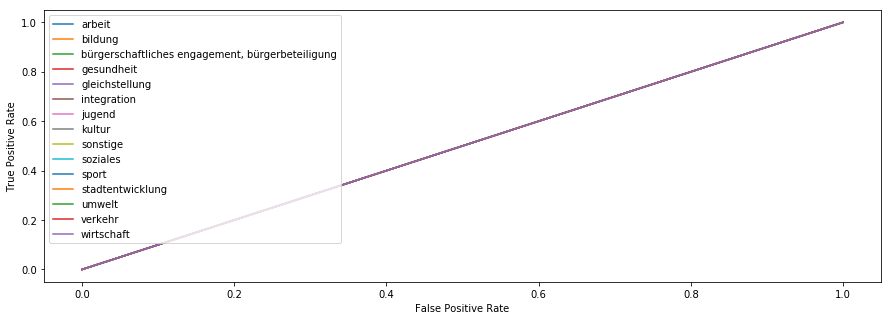

In [68]:
evaluate_model(clf_dummy.predict(X_train_red),
               clf_dummy.predict_proba(X_train_red),
               y_train_red,
               enc.classes_)

Die Performance des Dummy-Klassifikators ist erwartbar schlecht. Alle verwendeten Metriken belegen ein nicht vorhandenes Vorhersagevermögen. Insbesondere die AUC deutet auf völlig zufälliges vorhersagen hin.

Im Folgenden werden drei Modelle stichprobenartig gestet: KNN, RandomForest, SVM.
Wegen der geringen Anzahl an Features wird von einer Dimensionsreduktion zunächst abgesehen.

In [69]:
@ignore_warnings(category=FitFailedWarning)
@ignore_warnings(category=ConvergenceWarning)
def fit_explore(X, y, estimator, param_distributions, n_iter=100, score='neg_log_loss', partition=100):
    '''
    Führt für gegebne Klassifikator-Pipeline und Parameterset ein Hyperparamteroptimierung
    nach Zufallsprinzip aus.
    Training wärend des Optimierungsverfahrens wird mit einem verkleinertem Datenset (1/partition)
    durchgeführt um Zeit zu sparen.
    Anzahl an getesteten Parametersets gegeben durch 'n_iter'
    Scoring-Funktion optional wählbar.
    Model wird mit optimalen Hyperparametern und vollem Datensatz retrainiert.
    '''
    # definiere Suche
    rnd_search = RandomizedSearchCV(estimator, param_distributions=params,
                                n_iter=n_iter, cv=5, scoring=score, random_state=42, verbose=0, n_jobs=-1)

    # führe Suche aus
    rnd_search.fit(X[::partition], y[::partition])
    
    # retrainieren mit optimalen Hyperparametern
    estimator.set_params(**rnd_search.best_params_).fit(X, y)
    
    return estimator, rnd_search.best_params_

{'Estimator': RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=11, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=9,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False), 'Estimator__min_samples_split': 9, 'Estimator__max_depth': 11}
                                                  precision    recall  f1-score   support

                                          arbeit       0.82      1.00      0.90      7695
                                         bildung       0.81      0.24      0.37      1260
bürgerschaftliches engagement, bürgerbeteiligung       0.63      0.15      0.25       496
                  

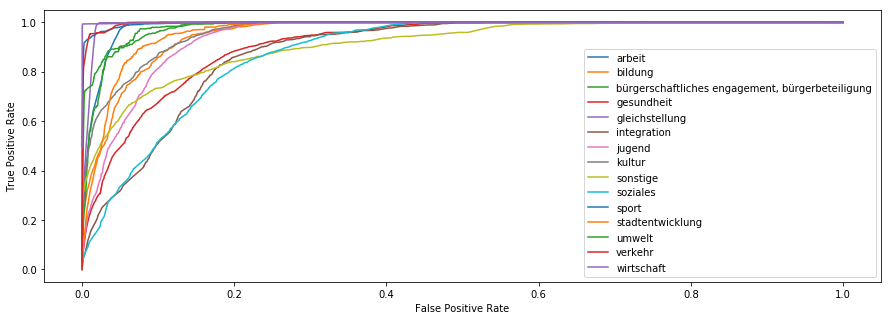

In [70]:
clf_pipe = Pipeline([
                                ('Estimator', None)
                            ])

params = [
    {
        'Estimator': [KNeighborsClassifier()],
        'Estimator__n_neighbors': randint(low=2, high=20),
        'Estimator__p': randint(low=1, high=4)
    },
    {
        'Estimator': [SVC(probability=True, random_state=42)],
        'Estimator__C': loguniform(1e-5, 10),
        'Estimator__kernel': ['linear', 'poly', 'rbf']
    },
    {
        'Estimator': [RandomForestClassifier(random_state=42)],
        'Estimator__max_depth': randint(low=5, high=50),
        'Estimator__min_samples_split': randint(low=5, high=10)
    }
]

best_model, best_config = fit_explore(X_train_red, y_train_red,
                                      estimator=clf_pipe,
                                      param_distributions=params,
                                      n_iter=15,
                                      partition=10,
                                      score='roc_auc_ovr')

print(best_config)

evaluate_model(best_model.predict(X_train_red),
               best_model.predict_proba(X_train_red),
               y_train_red,
               enc.classes_)

Die Leistung des besten, gefundenen Models lässt noch immer zu wünschen übrig. Für einige wenige Labels wie Wirstchaft, Sport und Verkehr ist die Vorhersagequalität fast perfekt(möglicherweise ein Indiz für Overtraining). Für die meißten aller Politikbereiche ist die Vorhersage zwar klar besser als geraten, aber es besteht durchaus Verbesserungsbedarf.

Ursachen sind zum einen die zu hohe Diversität der Zielgröße und deren ungleichmäßige Verteilung. Zum anderen wurden die Text-Analyse Features noch nicht in Betracht gezogen.

In [71]:
pd.DataFrame(best_model.named_steps.Estimator.feature_importances_,
          index=column_names,
          columns=['Feature Importance']
         ).sort_values(by='Feature Importance', ascending=False).head(8)

,Feature Importance
"senatsverwaltung für wirtschaft, energie und betriebe",0.239258
"senatsverwaltung für integration, arbeit und soziales",0.203018
senatsverwaltung für inneres und sport,0.166899
"senatsverwaltung für arbeit, integration und frauen",0.060469
senatsverwaltung für kultur und europa,0.058742
"senatsverwaltung für bildung, jugend und familie",0.034198
"senatsverwaltung für wirtschaft, technologie und forschung",0.031259
"senatsverwaltung für gesundheit, pflege und gleichstellung",0.026754


Weiter ist erkennbar, dass Entscheidungen fast ausschließlich auf Basis des 'Gebers' getroffen werden. Es ist also dringend notwendig weitere Features zu berücksichtigen.

## Einbeziehung der NLP Resultate

Der vollständige Datensatz liegt in Sparse-Matrix-Form for und ist nur von einer Hand von Algorithmen verwendbar. In Betracht gezogen werden: SVM & logistische Regression. Eine Reduktion der Dimensionalität wird in Form einer PCA erprobt.

In [72]:
X_train_red = colum_spec_pipeline.fit_transform(X_train)
X_test_red = colum_spec_pipeline.transform(X_test)

{'Estimator': LogisticRegression(C=6.958780103230357, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l1',
                   random_state=42, solver='saga', tol=0.0001, verbose=0,
                   warm_start=False), 'Estimator__C': 6.958780103230357, 'DimRed': None, 'Estimator__solver': 'saga', 'Estimator__penalty': 'l1'}
                                                  precision    recall  f1-score   support

                                          arbeit       1.00      1.00      1.00      7695
                                         bildung       0.98      0.98      0.98      1260
bürgerschaftliches engagement, bürgerbeteiligung       0.92      0.93      0.92       496
                                      gesundheit       0.98      0.97      0.98      1591
                                  gleichstellung       0.99      0.99      0.99       584

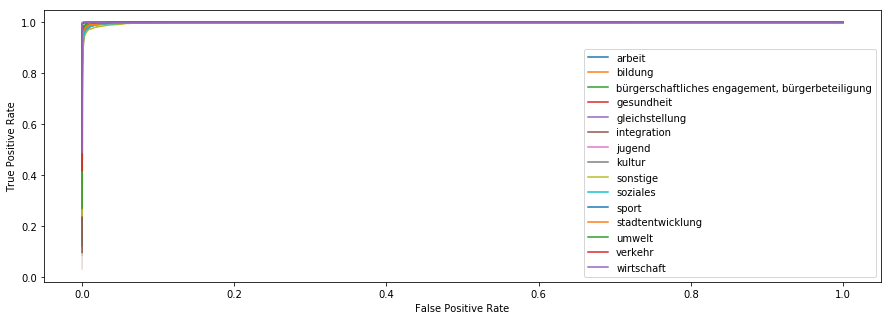

In [73]:
clf_pipe = Pipeline([
                                ('DimRed', None),
                                ('Estimator', None)
                            ])

params = [
    {
        'DimRed': [PCA(random_state=42)],
        'DimRed__n_components': randint(low=256, high=1024),
        'Estimator': [LogisticRegression(random_state=42)],
        'Estimator__penalty': ['l1', 'l2'],
        'Estimator__C': loguniform(1e-5, 10),
        'Estimator__solver': ['lbfgs', 'saga']
    },
    {
        'DimRed': [PCA(random_state=42)],
        'DimRed__n_components': randint(low=256, high=1024),
        'Estimator': [SVC(probability=True, random_state=42)],
        'Estimator__C': loguniform(1e-5, 10),
        'Estimator__kernel': ['linear', 'poly', 'rbf']
    },
    {
        'DimRed': [None],
        'Estimator': [RandomForestClassifier(random_state=42)],
        'Estimator__max_depth': randint(low=5, high=50),
        'Estimator__min_samples_split': randint(low=5, high=10)
    },
    {
        'DimRed': [None],
        'Estimator': [LogisticRegression(random_state=42)],
        'Estimator__penalty': ['l1', 'l2'],
        'Estimator__C': loguniform(1e-5, 10),
        'Estimator__solver': ['lbfgs', 'saga']
    }
]

best_model, best_config = fit_explore(X_train_red, y_train_red,
                                      estimator=clf_pipe,
                                      param_distributions=params,
                                      n_iter=15,
                                      partition=10,
                                      score='roc_auc_ovr')

print(best_config)

evaluate_model(best_model.predict(X_train_red),
               best_model.predict_proba(X_train_red),
               y_train_red,
               enc.classes_)

                                                  precision    recall  f1-score   support

                                          arbeit       0.98      0.99      0.99      3748
                                         bildung       0.90      0.85      0.88       637
bürgerschaftliches engagement, bürgerbeteiligung       0.69      0.66      0.67       235
                                      gesundheit       0.90      0.90      0.90       747
                                  gleichstellung       0.95      0.96      0.96       298
                                     integration       0.75      0.71      0.73       483
                                          jugend       0.83      0.88      0.85      1387
                                          kultur       0.84      0.88      0.86      1240
                                        sonstige       0.84      0.75      0.79      1127
                                        soziales       0.83      0.87      0.85       936
         

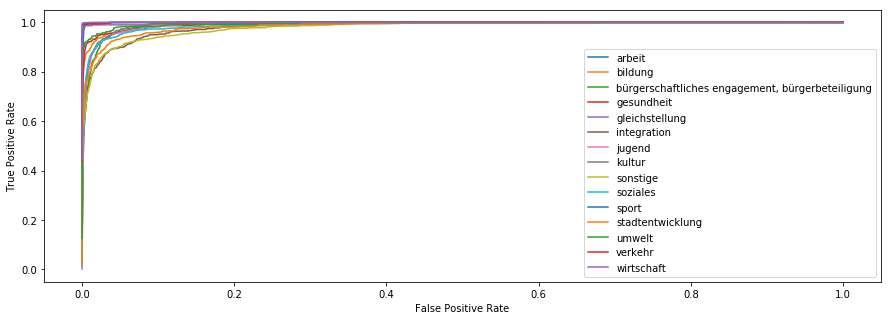

In [74]:
evaluate_model(best_model.predict(X_test_red),
               best_model.predict_proba(X_test_red),
               y_test_red,
               enc.classes_)

Das beinahe perfekte Resultat des besten Models auf seinen eigenen Trainingsdaten war, wie zu erwarten, ein Effekt des Overfittings. Auf den Testdaten offenbart sich, dass die Vorhersage für einige Politikbereiche (bspw. Integration) weniger belastbar ist.

Es überrascht, dass die Dimensionreduktion via PCA völlig abgelehnt wurde.

# Konklusion

Grundsätzlich scheint eine genaue Klassifizierung der Daten realisierbar. Eine feinere Optimierung der Hyperparameter des linearen Regressionmodels könnte bereits zu besseren Ergebnissen führen. Hierzu müssten mehr Zeit und Rechenleistung investiert werden. Vor allem der Einsatz einer stärkeren Regularisierung scheint vielversprechend. Zudem wurde bisher keinerlei Dimensionreduktion eingesetzt. Der Ansatz unter Verwendung einer PCA wurde vom Optimierungssystem abgelehnt. Andere Verfahren könnten einen Mehrgewinn ebieten.

Eine Hinzunahme weitere Daten, sofern verfügbar, könnte ebenfalls hilfreich sein. Diese könnten dazu genutzt werden, den Datensatz mit Blick auf die Zielgröße besser auszubalancieren. Sollten keine weiteren Daten verfügbar sein, können andere Methoden herangezogen werden; sowie Oversampling der eher seltenen Kategorien.

Eine weitere Reduktion der Kategorien der Zielgröße würde sehr wahrscheinlich zu besseren Ergebnissen führen. Allerdings würde das Model damit auch an Aussagekraft verlieren, da dadurch noch weitere Politikbereiche nicht mehr gesondert behandelt werden könnten, sondern nur unter die Kategorie Sonstige fielen. Darüber hinaus wäre es besser, wenn der Grenzwert für das Beibehalten von Kategorien nicht statisch auf 400 gesetzt wäre, sondern ein lernbarer Parameter würde. Durch eine Weiterentwicklung der Datenprozessionskette wäre dies möglich.

Der Einsatz von Deep Learning ist bei diesem Problem wohl nicht notwendig. Bereits ein simples, lineares Regressionmodel besitzt scheinbar eine ausreichende Komplexität, um den Datensatz inklusive zusätzlicher NLP-Features zu verallgemeinern.